In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


import time
import math
import random
import re
import os
import sys


from utils.util import find_files_with_extension
from utils.util import  get_dataframe_from_filepath,calculate_statistics, extract_unique_mbps_and_ms
from utils.util import remove_outliers_iqr, comma_format, create_directory_if_not_exists,print_rtt_stats,save_rtt_stats

In [14]:
# Load data
mainpth="./Data"

graph_directory = os.path.join(mainpth, "Graphs")
create_directory_if_not_exists(graph_directory)

stats_directory = os.path.join(mainpth, "Stats")
create_directory_if_not_exists(graph_directory)


folderpaths = [mainpth+'./client1_data',mainpth+'./client2_data']
filenames, filepaths, filedict = find_files_with_extension(folderpaths, '.log')


Directory already exists: ./Data\Graphs
Directory already exists: ./Data\Graphs


In [15]:
filedict

{'1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log': './Data./client1_data\\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log',
 '2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log': './Data./client1_data\\2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log',
 '1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log': './Data./client2_data\\1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log',
 '2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log': './Data./client2_data\\2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log'}

In [16]:
# Call the function and print unique combinations
unique_combinations = extract_unique_mbps_and_ms(folderpaths)
print("Unique Mbps and ms Combinations:")
for mbps, ms in sorted(unique_combinations):
    print(f'{mbps} Mbps, {ms} ms')


Unique Mbps and ms Combinations:
10 Mbps, 0 ms


In [17]:
mbps , ms = list(unique_combinations)[0]
net_settings = f'{mbps}_Mbps_{ms}_ms'
print(net_settings)

10_Mbps_0_ms


In [18]:
df=get_dataframe_from_filepath(filepaths[0])
df['ForeignPort'].unique()

./Data./client1_data\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log


array(['54191', '54201', '54207', '54209', '5102', '5101', '54180'],
      dtype=object)

In [19]:
unique_scenarios_dict={}
for index in range(len(filenames)):
    scenario = "_".join(filenames[index].split('_')[:4])
    if "l4s" in scenario:
        scenario = "_".join(filenames[index].split('_')[:3])
    if scenario in unique_scenarios_dict:
        unique_scenarios_dict[scenario].append(filedict[filenames[index]])
    else:
        unique_scenarios_dict[scenario]=[filedict[filenames[index]]]


In [20]:
unique_scenarios_dict

{'1_1_l4s': ['./Data./client1_data\\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log',
  './Data./client2_data\\1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log'],
 '2_2_l4s': ['./Data./client1_data\\2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log',
  './Data./client2_data\\2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log']}

In [21]:
from utils.plotter import  plot_siftr_graph


Start New Scenario
1_1_l4s
./Data./client1_data\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log

Start New Scenario
2_2_l4s
./Data./client1_data\2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


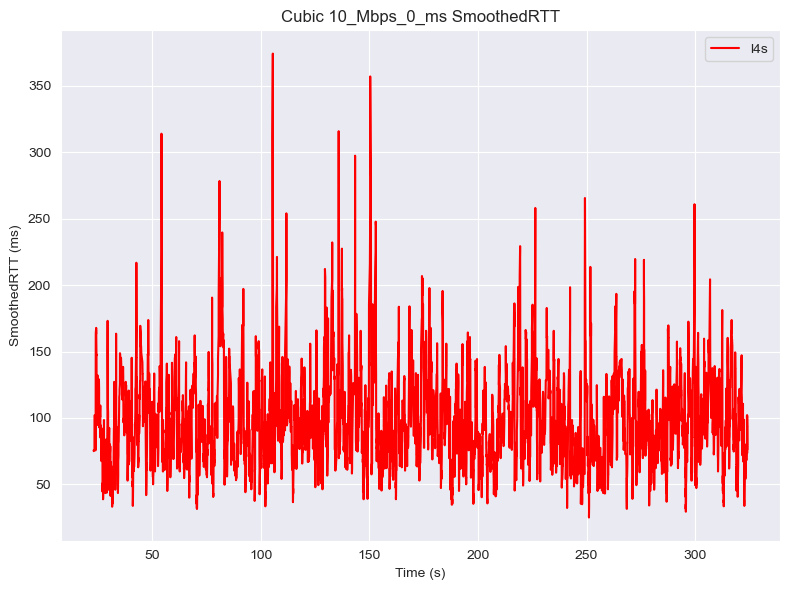

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


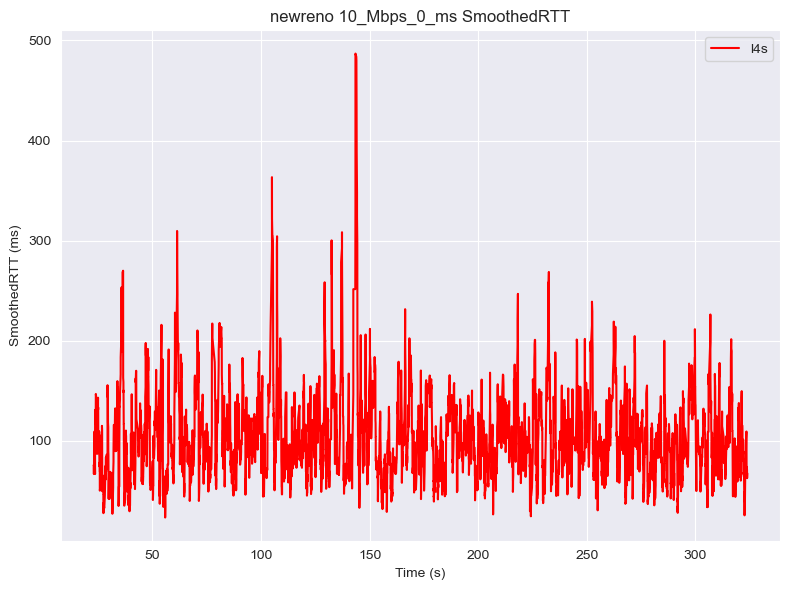

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


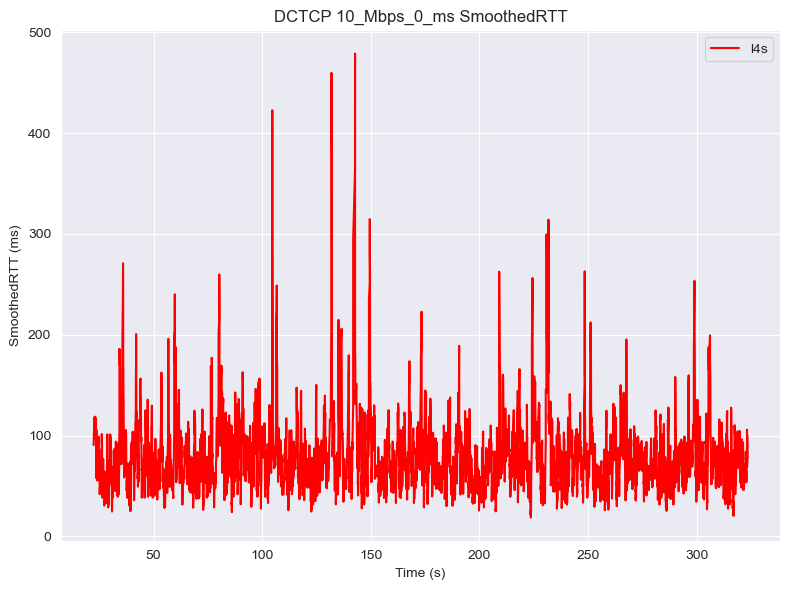

In [22]:
cubic_paths = {}
newreno_paths = {}
dctcp_paths = {}

aqms =["fq_codel","fq_pie","l4s"]

for scenario in list(unique_scenarios_dict.keys())[:3]:
    
    tcp1 = "CUBIC"
    tcp2 = "NEWRENO"
    tcp3 = "DCTCP"
    print()
    print("Start New Scenario")
    print(scenario)

    classif_traffic = unique_scenarios_dict[scenario][0]
    l4s_traffic = unique_scenarios_dict[scenario][1]

    ctf = get_dataframe_from_filepath(classif_traffic)
    ltf = get_dataframe_from_filepath(l4s_traffic)

    ctf1 = ctf[ctf['ForeignPort'] == "5101"]
    ctf2 = ctf[ctf['ForeignPort'] == "5102"]
    ltf =  ltf[ltf['ForeignPort'] == "5103"]

    # Define paths
    paths = {
        tcp1: ctf1,
        tcp2: ctf2,
        tcp3: ltf,
    }
    for aqm in aqms:
        if aqm in scenario:
            # print(aqm)
            cubic_paths[aqm] = ctf1
            newreno_paths[aqm] = ctf2
            dctcp_paths[aqm] = ltf


plot_siftr_graph(paths=cubic_paths,
                ycolumn="SmoothedRTT",
                title=f'Cubic {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'Cubic_{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)

plot_siftr_graph(paths=newreno_paths,
                ycolumn="SmoothedRTT",
                title=f'newreno {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'newreno{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)


plot_siftr_graph(paths=dctcp_paths,
                ycolumn="SmoothedRTT",
                title=f'DCTCP {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'DCTCP_{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)



Start New Scenario
1_1_l4s
./Data./client1_data\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log

Start New Scenario
2_2_l4s
./Data./client1_data\2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


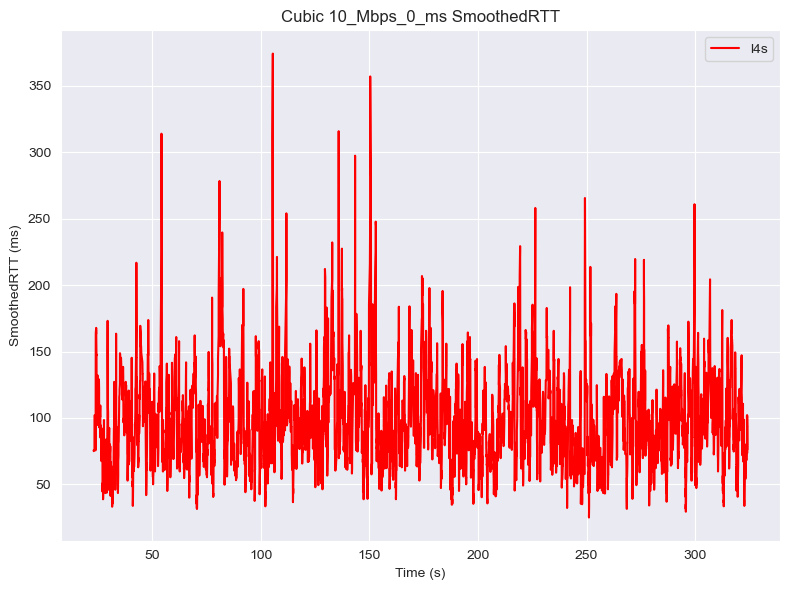

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


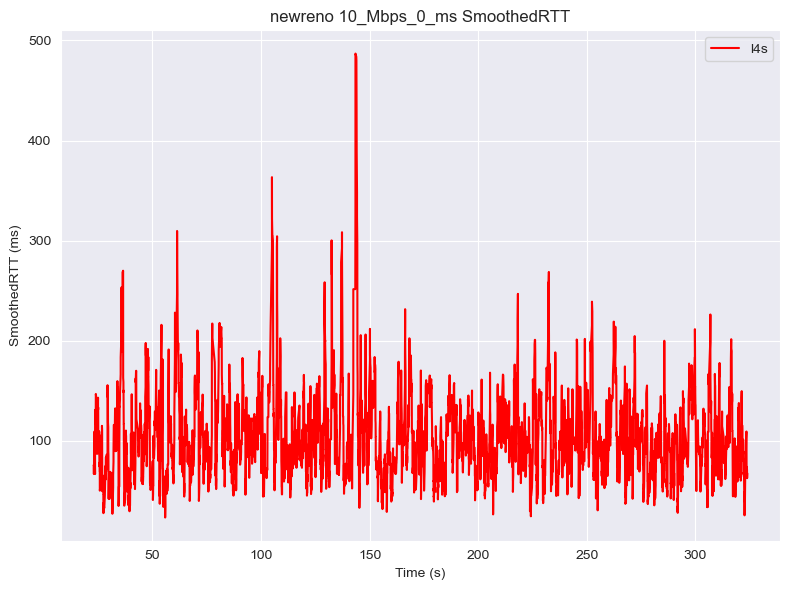

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


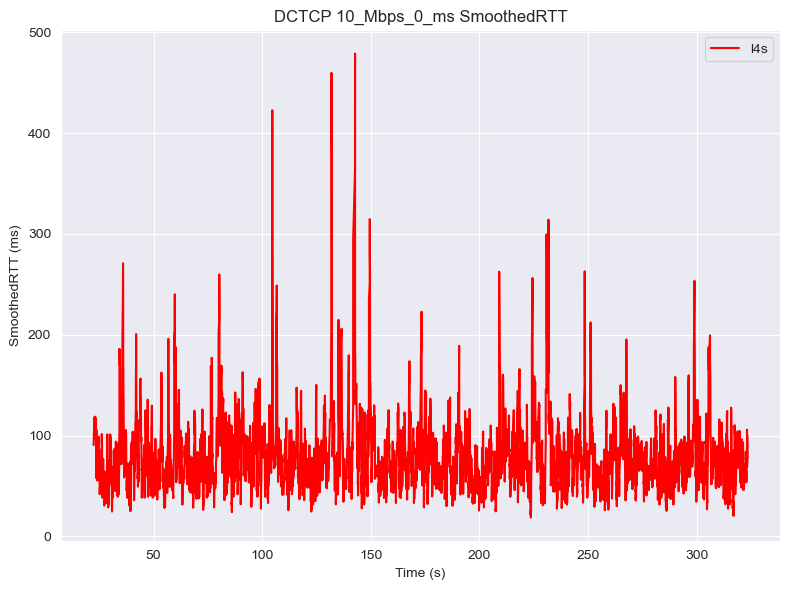

In [23]:
cubic_paths = {}
newreno_paths = {}
dctcp_paths = {}

aqms =["fq_codel","fq_pie","l4s"]
aqms =["fq_pie","l4s"]

for scenario in list(unique_scenarios_dict.keys())[:3]:
    
    tcp1 = "CUBIC"
    tcp2 = "NEWRENO"
    tcp3 = "DCTCP"
    print()
    print("Start New Scenario")
    print(scenario)

    classif_traffic = unique_scenarios_dict[scenario][0]
    l4s_traffic = unique_scenarios_dict[scenario][1]

    ctf = get_dataframe_from_filepath(classif_traffic)
    ltf = get_dataframe_from_filepath(l4s_traffic)

    ctf1 = ctf[ctf['ForeignPort'] == "5101"]
    ctf2 = ctf[ctf['ForeignPort'] == "5102"]
    ltf =  ltf[ltf['ForeignPort'] == "5103"]

    # Define paths
    paths = {
        tcp1: ctf1,
        tcp2: ctf2,
        tcp3: ltf,
    }
    for aqm in aqms:
        if aqm in scenario:
            # print(aqm)
            cubic_paths[aqm] = ctf1
            newreno_paths[aqm] = ctf2
            dctcp_paths[aqm] = ltf


plot_siftr_graph(paths=cubic_paths,
                ycolumn="SmoothedRTT",
                title=f'Cubic {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'Cubic_{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)

plot_siftr_graph(paths=newreno_paths,
                ycolumn="SmoothedRTT",
                title=f'newreno {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'newreno{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)


plot_siftr_graph(paths=dctcp_paths,
                ycolumn="SmoothedRTT",
                title=f'DCTCP {net_settings} SmoothedRTT',
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'DCTCP_{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)



Start New Scenario
1_1_l4s
./Data./client1_data\1_1_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\1_1_l4s_10Mbps_0ms_dctcp_src2.siftr.log

RTT *-*-*RTT *-*-*RTT *-*-*RTT *-*-*RTT *-*-*
RTT statistics for scenario 1_1_l4s_10_Mbps_0_ms:
Statistics for CUBIC:
Median: 89.062
Mean: 97.2834482553697
25th Percentile: 69.687
75th Percentile: 115.312
Minimum: 20.0
Maximum: 365.937
Statistics for NEWRENO:
Median: 89.062
Mean: 97.89404911107198
25th Percentile: 70.937
75th Percentile: 115.0
Minimum: 24.687
Maximum: 369.375
Statistics for DCTCP:
Median: 69.375
Mean: 76.93032658720792
25th Percentile: 54.062
75th Percentile: 88.75
Minimum: 22.812
Maximum: 477.5
END RTT *-*-*END RTT *-*-*END RTT *-*-*END RTT *-*-*END RTT *-*-*


Saving RTT statistics to ./Data\Stats/scn_1_1_l4s_10_Mbps_0_ms_rtt_stats.txt


Start New Scenario
2_2_l4s
./Data./client1_data\2_2_l4s_10Mbps_0ms_newreno_src1.siftr.log
./Data./client2_data\2_2_l4s_10Mbps_0ms_dctcp_src2.siftr.log

RTT *-*-*RTT *-*-*RTT *-*-*RTT

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


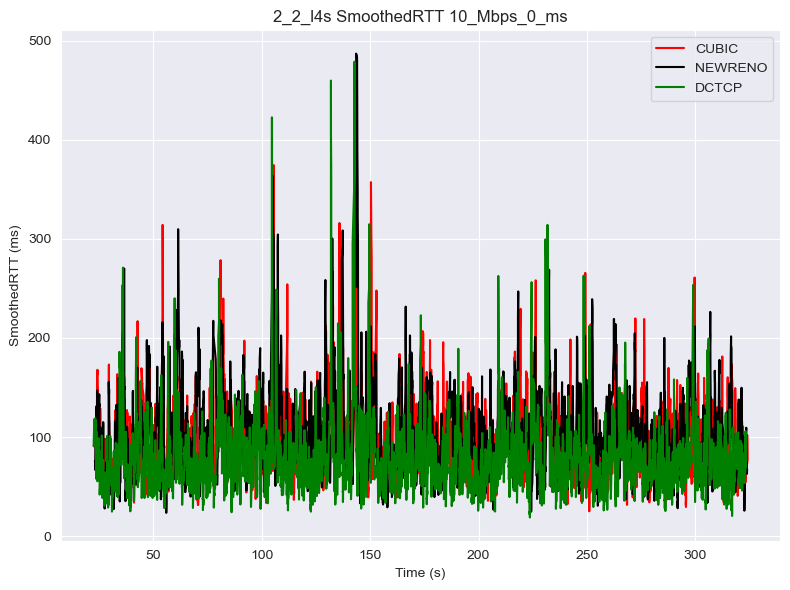

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


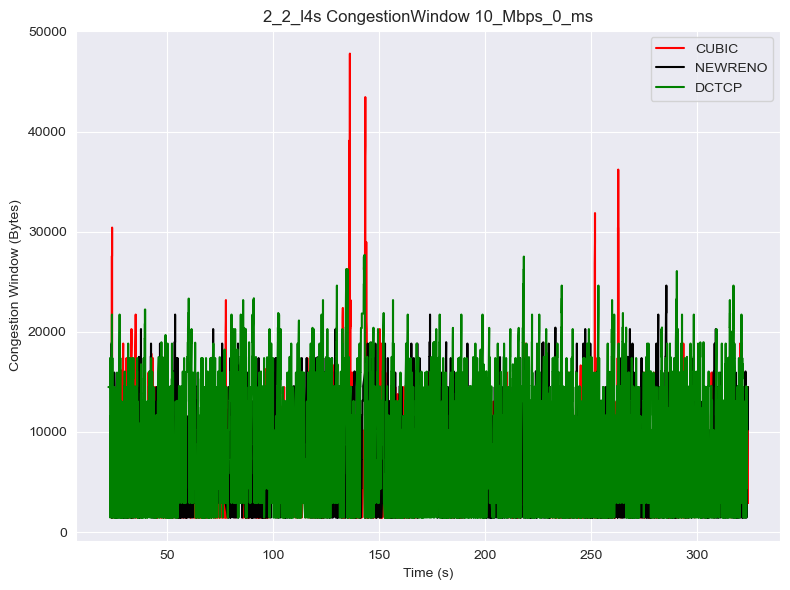

In [24]:
paths = {}
for scenario in unique_scenarios_dict.keys():

    tcp1 = "CUBIC"
    tcp2 = "NEWRENO"
    tcp3 = "DCTCP"
    print()
    print("Start New Scenario")
    print(scenario)

    classif_traffic = unique_scenarios_dict[scenario][0]
    l4s_traffic = unique_scenarios_dict[scenario][1]

    ctf = get_dataframe_from_filepath(classif_traffic)
    ltf = get_dataframe_from_filepath(l4s_traffic)

    ctf1 = ctf[ctf['ForeignPort'] == "5101"]
    ctf2 = ctf[ctf['ForeignPort'] == "5102"]
    ltf =  ltf[ltf['ForeignPort'] == "5103"]

    # Define paths
    paths = {
        tcp1: ctf1,
        tcp2: ctf2,
        tcp3: ltf,
    }

    print_rtt_stats(paths=paths,scenario=scenario+"_"+net_settings)
    save_rtt_stats(paths=paths,scenario=scenario+"_"+net_settings,stats_directory=stats_directory)




plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT {net_settings}",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}_{net_settings}_SmoothedRTT',
                graph_directory=graph_directory,
)




plot_siftr_graph(paths=paths,
                ycolumn="CongestionWindow",
                title=f"{scenario} CongestionWindow {net_settings}",
                xlabel="Time (s)",
                ylabel="Congestion Window (Bytes)",
                filename=f'{scenario}_{net_settings}_CWND',
                graph_directory=graph_directory,
)
